- Reading, Understanding and Visualising the data
- Preparing the data for modeling
  - Splitting the train-test data
  - Scaling the data
- Training the model
- Residual Analysis
- Predictions and Evaluation on the test set


### Reading, Understanding and Visualising the data

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [107]:
housing = pd.read_csv('../datasets/delhi_housing.csv')
housing.head()
housing.shape
housing.info()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


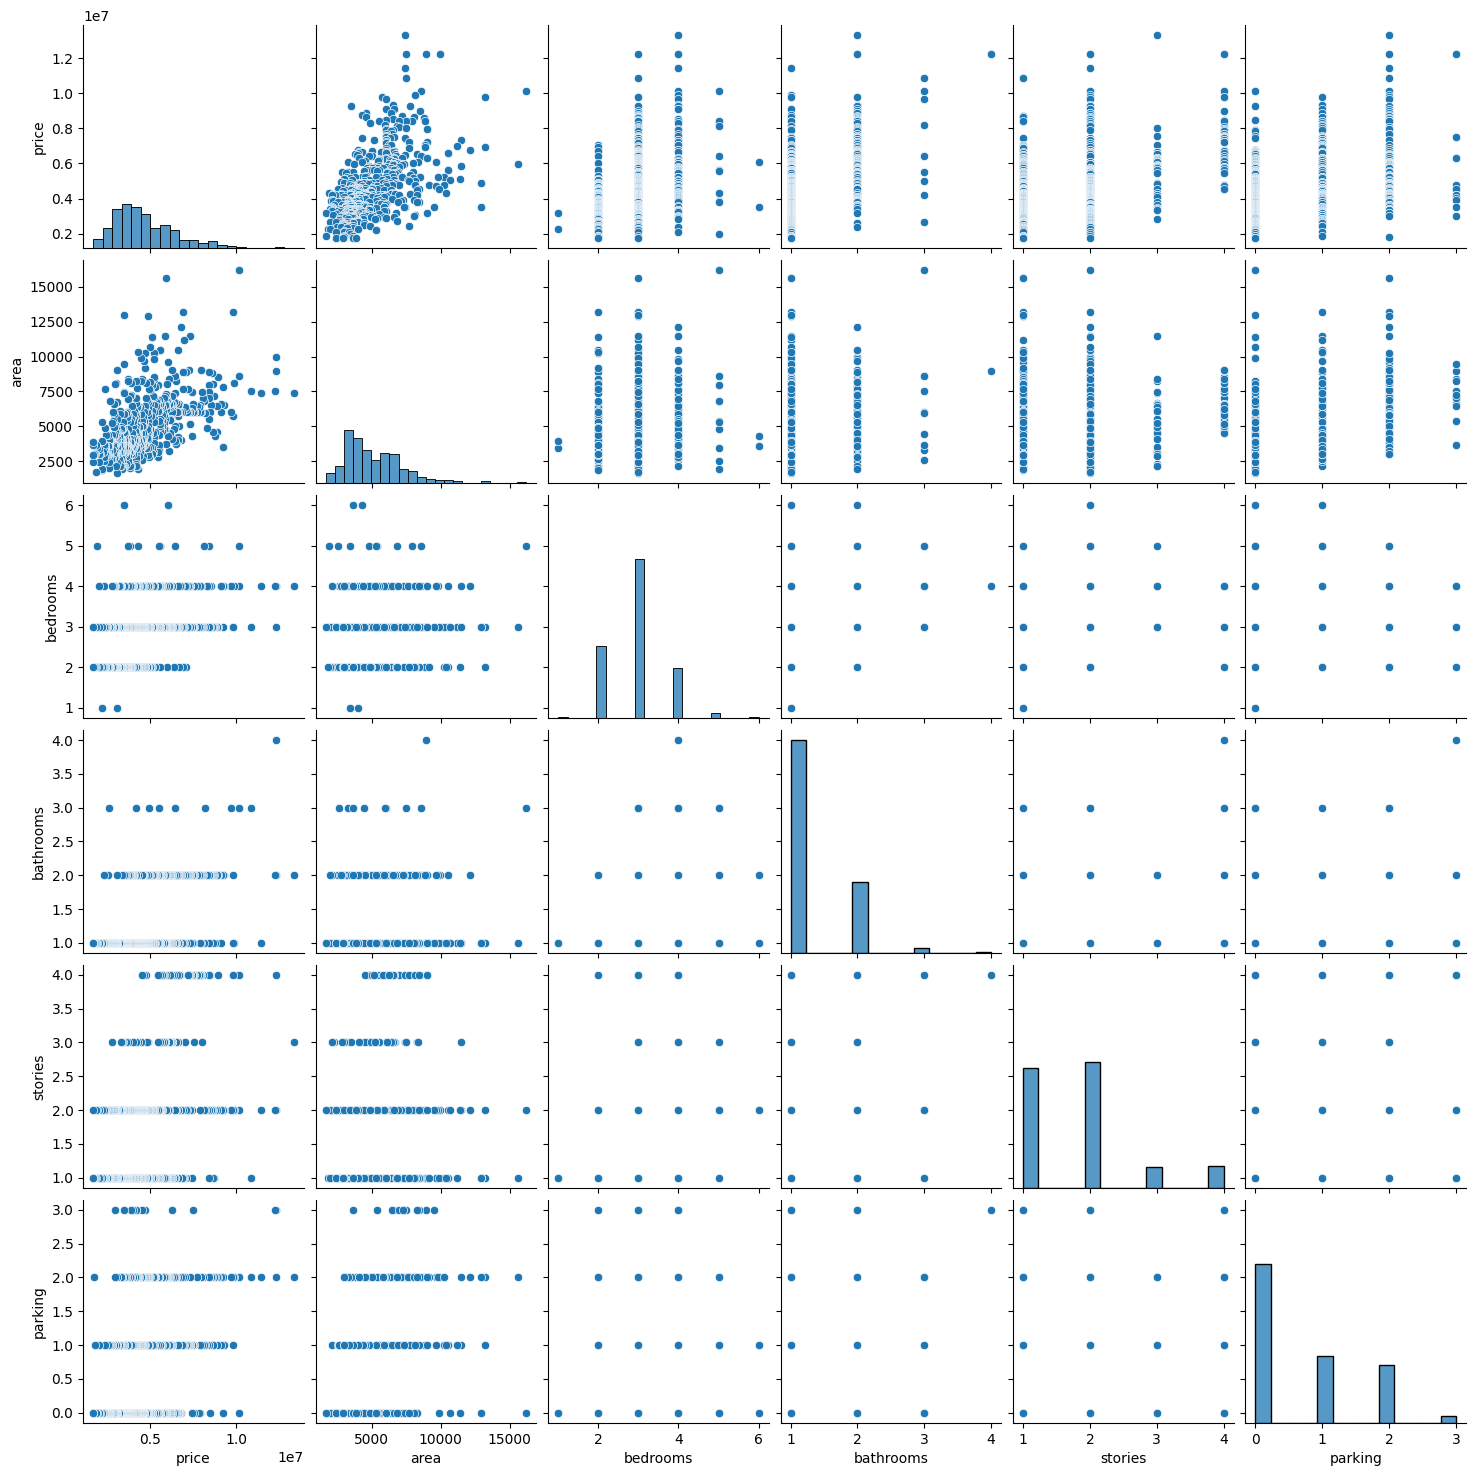

In [108]:
# Visualize the numerical variables
# Whether a linear regression model make sense or not
# If the 'price' is not related to any of the other variables then the linear regression is not possible
# Making sure that linear relationship does exist
sns.pairplot(housing)
plt.show()

# The relationship between the price and area is a positive correlation
# For 2, 3, 4 bedrooms there seems to be a positive correlation with the price
# For 1, 2 parkings there seems to be a positive correlation with the price


<Axes: xlabel='furnishingstatus', ylabel='price'>

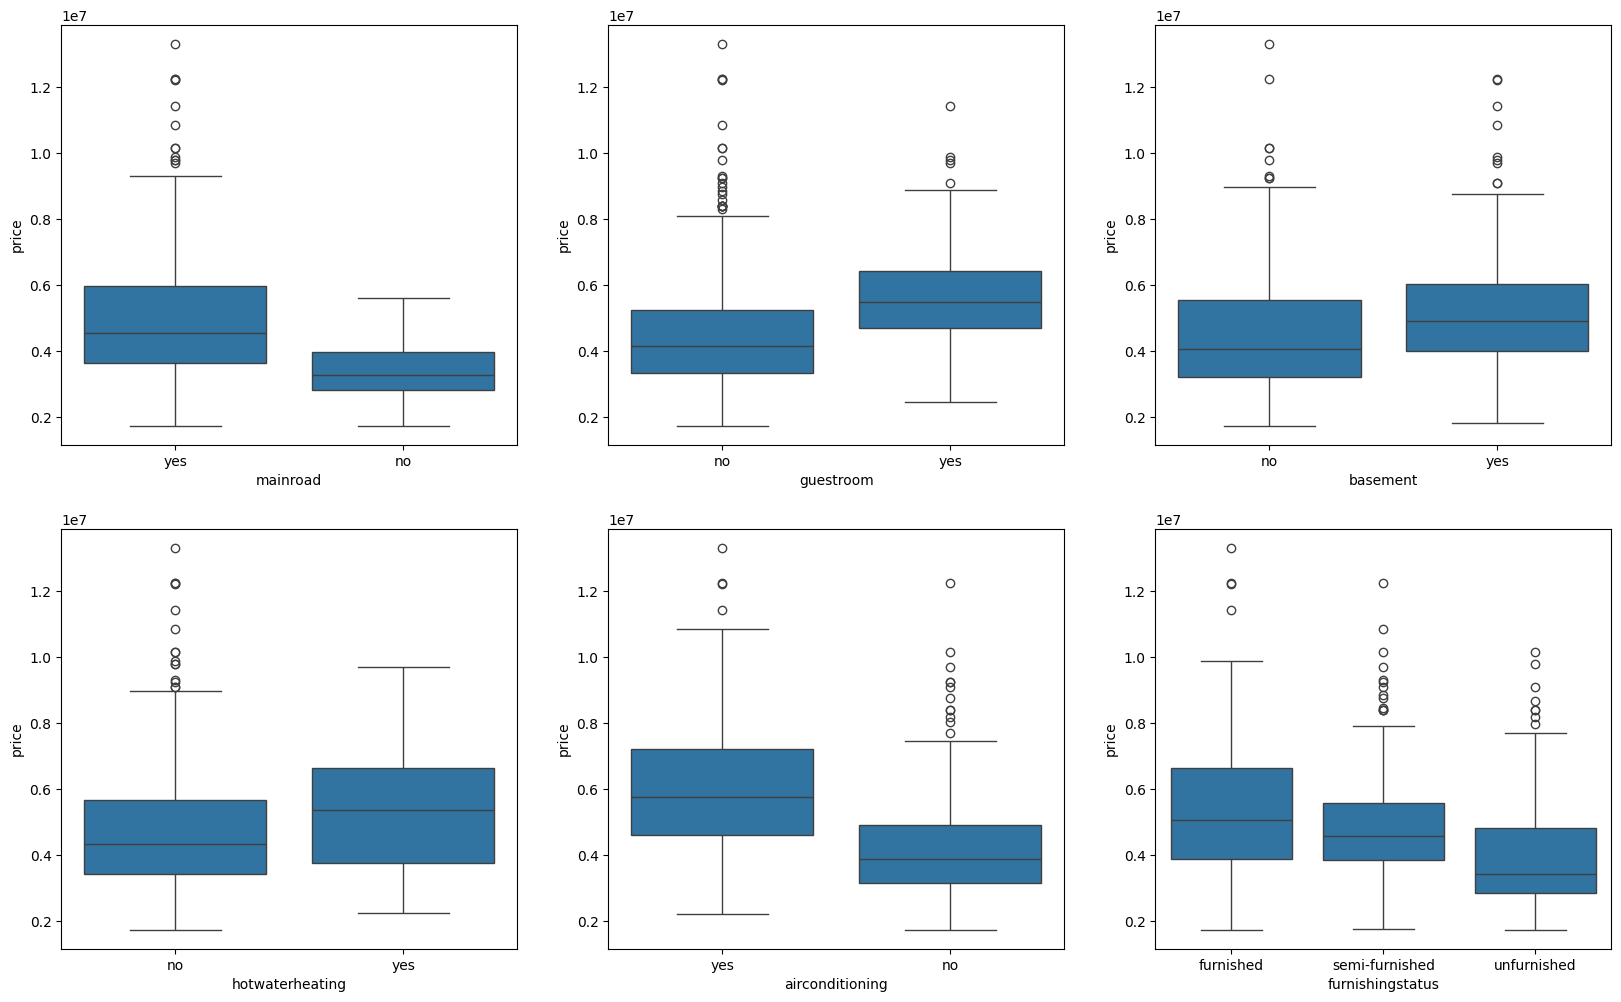

In [109]:
# Visualise the categorical variables
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
sns.boxplot(x = 'mainroad', y = 'price', data=housing)

plt.subplot(2, 3, 2)
sns.boxplot(x = 'guestroom', y = 'price', data=housing)

plt.subplot(2, 3, 3)
sns.boxplot(x = 'basement', y = 'price', data=housing)

plt.subplot(2, 3, 4)
sns.boxplot(x = 'hotwaterheating', y = 'price', data=housing)

plt.subplot(2, 3, 5)
sns.boxplot(x = 'airconditioning', y = 'price', data=housing)

plt.subplot(2, 3, 6)
sns.boxplot(x = 'furnishingstatus', y = 'price', data=housing)

# When the houses are located on the mainroad the mean is significantly higher than the ones which are not
# When the houses have guestroom the mean is significantly higher than the ones which are not
# When the houses have airconditioning the mean is significantly higher than the ones which are not
# When the houses are furnished the mean is significantly higher than the ones which are not

### Data Prepration

In [110]:
# Whenever we have variables with values yes/no or true/false, convert them to 1/0
# Whenever we have variables with enum values like for furnishing status 'furnished', 'semi-furnished', 'unfurnished', convert them using dummy
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[varlist] = housing[varlist].apply(lambda x: x.map({'yes': 1, 'no': 0}))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [111]:
dummies = pd.get_dummies(housing['furnishingstatus'], drop_first=True)
dummies = dummies.apply(lambda x: x.map({True: 1, False: 0}))
housing = pd.concat([housing, dummies], axis=1)
housing = housing.drop('furnishingstatus', axis=1)

In [112]:
df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)
print("Train data size: ", df_train.shape)
print("Test data size: ", df_test.shape)

Train data size:  (381, 14)
Test data size:  (164, 14)


In [113]:
scaler = MinMaxScaler()

num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


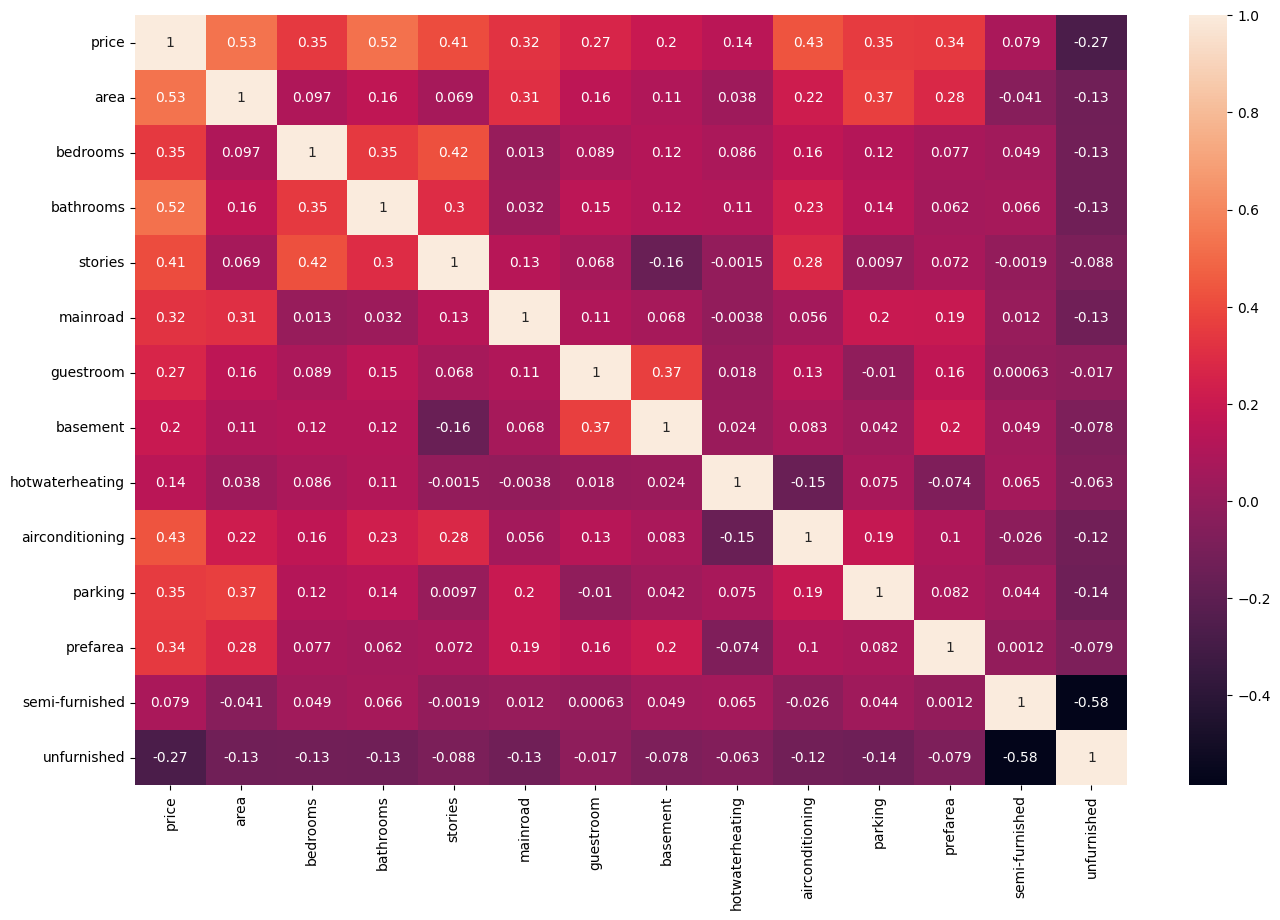

In [114]:
# Determine the correlation between the Predictor Variables.
plt.figure(figsize=(16,10))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [115]:
y_train = df_train.pop('price')
X_train = df_train

In [116]:
X_train_sm = sm.add_constant(X_train['area'])

lr = sm.OLS(y_train, X_train_sm)

lr_model_1 = lr.fit()

lr_model_1.params

lr_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           3.15e-29
Time:                        22:45:21   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.000       0.102       0.152
area           0.4622      0.038     12.232      0.000       0.388       0.536
==============================================================================
Omnibus:                       67.313   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.063
Skew:                           0.925   Prob(JB):                     8.59e-32
Kurtosis:                       5.365   Cond. No.                         5.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
X_train_sm = X_train[['area', 'bathrooms']]
X_train_sm = sm.add_constant(X_train_sm)

lr = sm.OLS(y_train, X_train_sm)

lr_model_2 = lr.fit()

lr_model_2.params

lr_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.51e-54
Time:                        22:45:21   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.000       0.083       0.127
area           0.3984      0.033     12.192      0.000       0.334       0.463
bathrooms      0.2984      0.025     11.945      0.000       0.249       0.347
==============================================================================
Omnibus:                       62.839   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.790
Skew:                           0.784   Prob(JB):                     2.23e-37
Kurtosis:                       5.859   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
X_train_sm = X_train[['area', 'bathrooms', 'bedrooms']]
X_train_sm = sm.add_constant(X_train_sm)

lr = sm.OLS(y_train, X_train_sm)

lr_model_3 = lr.fit()

lr_model_3.params

lr_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           3.12e-57
Time:                        22:45:21   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0414      0.018      2.292      0.022       0.006       0.077
area           0.3922      0.032     12.279      0.000       0.329       0.455
bathrooms      0.2600      0.026     10.033      0.000       0.209       0.311
bedrooms       0.1819      0.041      4.396      0.000       0.101       0.263
==============================================================================
Omnibus:                       50.037   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.806
Skew:                           0.648   Prob(JB):                     7.92e-28
Kurtosis:                       5.487   Cond. No.                         8.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
X_train_sm = X_train[['area', 'bathrooms', 'bedrooms', 'airconditioning']]
X_train_sm = sm.add_constant(X_train_sm)

lr = sm.OLS(y_train, X_train_sm)

lr_model_4 = lr.fit()

lr_model_4.params

lr_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     118.5
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.77e-65
Time:                        22:45:21   Log-Likelihood:                 319.19
No. Observations:                 381   AIC:                            -628.4
Df Residuals:                     376   BIC:                            -608.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0397      0.017      2.323      0.021       0.006       0.073
area                0.3546      0.031     11.530      0.000       0.294       0.415
bathrooms           0.2329      0.025      9.370      0.000       0.184       0.282
bedrooms            0.1598      0.039      4.066      0.000       0.083       0.237
airconditioning     0.0828      0.012      6.691      0.000       0.058       0.107
==============================================================================
Omnibus:                       57.748   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.632
Skew:                           0.761   Prob(JB):                     1.30e-30
Kurtosis:                       5.520   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_sm)

lr_model_5 = lr.fit()

lr_model_5.params

lr_model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           8.83e-83
Time:                        22:45:21   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021      0.955      0.340      -0.021       0.061
area                0.2347      0.030      7.795      0.000       0.175       0.294
bedrooms            0.0467      0.037      1.267      0.206      -0.026       0.119
bathrooms           0.1908      0.022      8.679      0.000       0.148       0.234
stories             0.1085      0.019      5.661      0.000       0.071       0.146
mainroad            0.0504      0.014      3.520      0.000       0.022       0.079
guestroom           0.0304      0.014      2.233      0.026       0.004       0.057
basement            0.0216      0.011      1.943      0.053      -0.000       0.043
hotwaterheating     0.0849      0.022      3.934      0.000       0.042       0.127
airconditioning     0.0669      0.011      5.899      0.000       0.045       0.089
parking             0.0607      0.018      3.365      0.001       0.025       0.096
prefarea            0.0594      0.012      5.040      0.000       0.036       0.083
semi-furnished      0.0009      0.012      0.078      0.938      -0.022       0.024
unfurnished        -0.0310      0.013     -2.440      0.015      -0.056      -0.006
==============================================================================
Omnibus:                       93.687   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.917
Skew:                           1.091   Prob(JB):                     6.14e-67
Kurtosis:                       6.801   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
vif = pd.DataFrame()
vif["Feature"] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by= 'VIF', ascending=False)

In [122]:
X = X_train.drop('semi-furnished', axis=1)

X_train_sm = sm.add_constant(X)

lr = sm.OLS(y_train, X_train_sm)

lr_model_5 = lr.fit()

lr_model_5.params

lr_model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           1.07e-83
Time:                        22:45:21   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0207      0.019      1.098      0.273      -0.016       0.058
area                0.2344      0.030      7.845      0.000       0.176       0.293
bedrooms            0.0467      0.037      1.268      0.206      -0.026       0.119
bathrooms           0.1909      0.022      8.697      0.000       0.148       0.234
stories             0.1085      0.019      5.669      0.000       0.071       0.146
mainroad            0.0504      0.014      3.524      0.000       0.022       0.079
guestroom           0.0304      0.014      2.238      0.026       0.004       0.057
basement            0.0216      0.011      1.946      0.052      -0.000       0.043
hotwaterheating     0.0849      0.022      3.941      0.000       0.043       0.127
airconditioning     0.0668      0.011      5.923      0.000       0.045       0.089
parking             0.0608      0.018      3.372      0.001       0.025       0.096
prefarea            0.0594      0.012      5.046      0.000       0.036       0.083
unfurnished        -0.0316      0.010     -3.096      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       93.538   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.844
Skew:                           1.090   Prob(JB):                     1.05e-66
Kurtosis:                       6.794   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by= 'VIF', ascending=False)
vif

,Feature,VIF
1,bedrooms,6.59
4,mainroad,5.68
0,area,4.67
3,stories,2.69
9,parking,2.12
6,basement,2.01
8,airconditioning,1.77
2,bathrooms,1.67
10,prefarea,1.51
5,guestroom,1.47


In [124]:
X = X.drop('bedrooms', axis=1)

X_train_sm = sm.add_constant(X)

lr = sm.OLS(y_train, X_train_sm)

lr_model_6 = lr.fit()

lr_model_6.params

lr_model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.73e-84
Time:                        22:45:21   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015      2.421      0.016       0.007       0.065
area                0.2347      0.030      7.851      0.000       0.176       0.294
bathrooms           0.1965      0.022      9.132      0.000       0.154       0.239
stories             0.1178      0.018      6.654      0.000       0.083       0.153
mainroad            0.0488      0.014      3.423      0.001       0.021       0.077
guestroom           0.0301      0.014      2.211      0.028       0.003       0.057
basement            0.0239      0.011      2.183      0.030       0.002       0.045
hotwaterheating     0.0864      0.022      4.014      0.000       0.044       0.129
airconditioning     0.0665      0.011      5.895      0.000       0.044       0.089
parking             0.0629      0.018      3.501      0.001       0.028       0.098
prefarea            0.0596      0.012      5.061      0.000       0.036       0.083
unfurnished        -0.0323      0.010     -3.169      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       97.661   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.388
Skew:                           1.130   Prob(JB):                     2.20e-71
Kurtosis:                       6.923   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by= 'VIF', ascending=False)
vif

,Feature,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


In [126]:
y_train_predicted = lr_model_6.predict(X_train_sm)

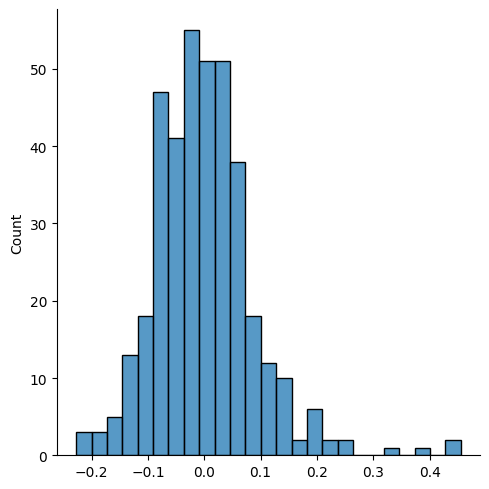

In [127]:
res = y_train - y_train_predicted
sns.displot(res)

In [128]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
y_test = df_test.pop('price')
X_test = df_test

X_test_sm = sm.add_constant(X_test)
X_test_sm = X_test_sm.drop(['bedrooms', 'semi-furnished'], axis=1)

In [133]:
y_test_predict = lr_model_6.predict(X_test_sm)

r2_score(y_true=y_test, y_pred=y_test_predict)

0.6713505684480789

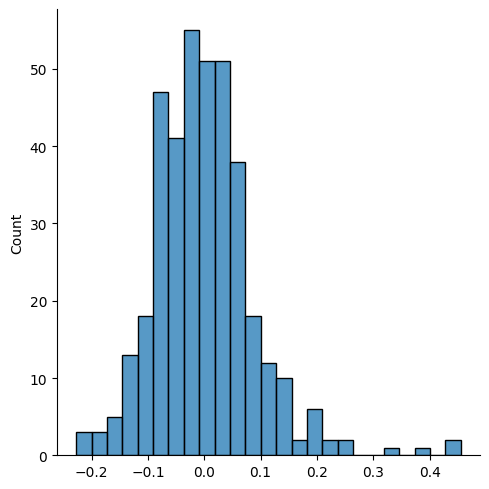

In [134]:
y_train_predict = lr_model_6.predict(X_train_sm)

#r2_score(y_true=y_test, y_pred=y_test_predict)

res = y_train - y_train_predict

sns.displot(res)

In [147]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))


X_train.columns[rfe.support_]

Index(['area', 'bathrooms', 'stories', 'hotwaterheating', 'airconditioning',
       'prefarea'],
      dtype='object')